## 基于飞桨实现乒乓球时序动作定位大赛 ：B榜第12名方案

### 赛题介绍

在众多大规模视频分析情景中，从冗长未经修剪的视频中定位并识别短时间内发生的人体动作成为一个备受关注的课题。当前针对人体动作检测的解决方案在大规模视频集上难以奏效，高效地处理大规模视频数据仍然是计算机视觉领域一个充满挑战的任务。其核心问题可以分为两部分，一是动作识别算法的复杂度仍旧较高，二是缺少能够产生更少视频提案数量的方法（更加关注短时动作本身的提案）。

这里所指的视频动作提案是指一些包含特定动作的候选视频片段。为了能够适应大规模视频分析任务，时序动作提案应该尽可能满足下面两个需求：
（1）更高的处理效率，例如可以设计出使时序视频片段编码和打分更高效的机制；
（2）更强的判别性能，例如可以准确定位动作发生的时间区间。

本次比赛旨在激发更多的开发者和研究人员关注并参与有关视频动作定位的研究，创建性能更出色的动作定位模型。

### 数据集介绍

本次比赛的数据集包含了19-21赛季兵乓球国际比赛（世界杯、世锦赛、亚锦赛，奥运会）和国内比赛（全运会，乒超联赛）中标准单机位高清转播画面的特征信息，共包含912条视频特征文件，每个视频时长在0～6分钟不等，特征维度为2048，以pkl格式保存。我们对特征数据中面朝镜头的运动员的回合内挥拍动作进行了标注，单个动作时常在0～2秒不等，训练数据为729条标注视频，A测数据为91条视频，B测数据为92条视频，训练数据标签以json格式给出。

本赛题中的数据包含912条ppTSM抽取的视频特征，特征保存为pkl格式，文件名对应视频名称，读取pkl之后以(num_of_frames, 2048)向量形式代表单个视频特征。其中num_of_frames是不固定的，同时数量也比较大，所以pkl的文件并不能直接用于训练。同时由于乒乓球每个动作时间非常短，为了可以让模型更好的识别动作，所以需要将数据进行分割。

### 思路介绍

* 本赛题的视频数据帧数不固定，单个pkl文件包含的乒乓球动作数量也不固定，参考[BMN_tabletennis](https://github.com/PaddlePaddle/PaddleVideo/blob/develop/applications/TableTennis/get_instance_for_bmn.py)的数据分割方式，使用宽4s的滑窗,把每一个视频里的动作片段提取出来,分割为4X25=100帧的数据。
* 本项目基于[BMN](https://github.com/PaddlePaddle/PaddleVideo/blob/develop/docs/zh-CN/model_zoo/localization/bmn.md)模型开发,借鉴[TVNet](https://arxiv.org/abs/2201.00434)中对TEM模块的改进思路，将TEM改成双分支融合后直接输出xs\xe的思路。
* 改进了删除冗余proposal的策略，将原本的Soft-NMS改进为DIOU-soft-NMS，避免漏检。

### 具体方案分享

1. 整体流程框图

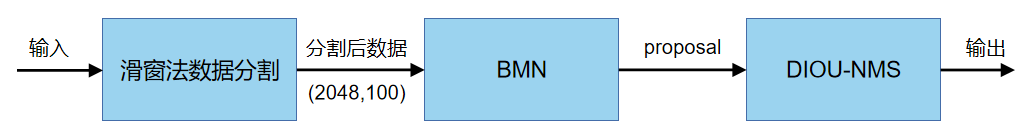

2. BMN模型结构

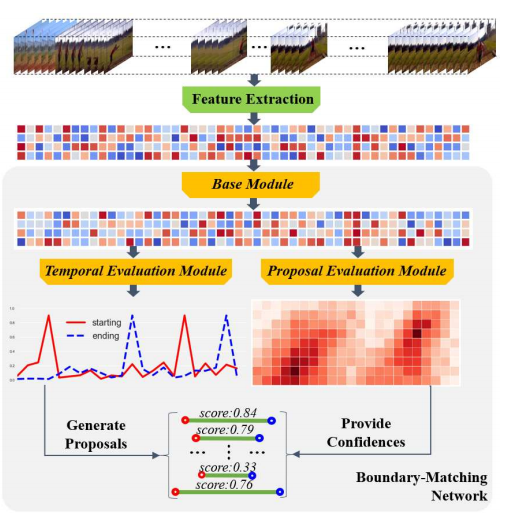

3. TEM模块改进

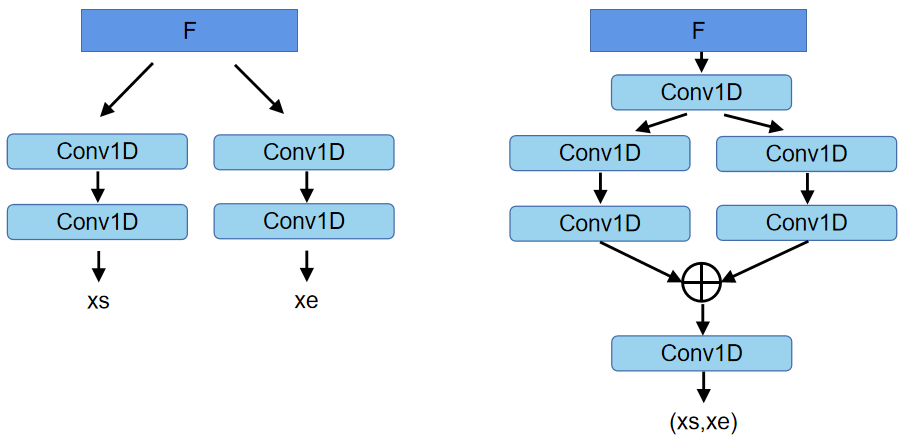

BMN中原本的TEM实现为两个分支单独进行xs和xe的预测，考虑到一个动作的起止互相是具有强关联性的，起始时间和终止时间的特征应该共同用于预测，因此改进后的TEM模块先通过两个分支分别提取起始时间和终止时间相关的特征，再将特征进行融合最后预测输出。

4. DIOU-soft-NMS

原本的Soft-NMS采用IOU来表示proposal的重叠程度以判断冗余性，而预测过程中可能出现强包含关系如下图所示:

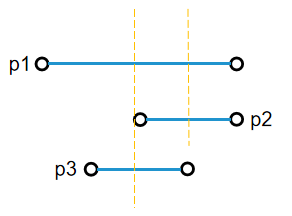

p1与p2、p3具有相同的重叠度，但很明显p1与p2中心点重合大概率为同一动作的不同保守程度的估计，而p1与p3中心点偏离较大，可以认为是两个不同的动作。

为了避免漏检p3这样的动作，本项目采用diou来替代iou进行非极大值抑制，diou的计算公式如下:

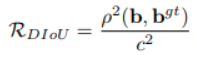

其中ρ(·)是两proposal中心点的欧几里得距离，c是覆盖两个proposal的最小时间长度。

### 代码运行与训练测试

1. 首先解压数据集
执行以下命令解压数据集，解压之后将压缩包删除，保证项目空间小于100G。否则项目会被终止。

In [1]:
%cd /home/aistudio/data/
!tar xf data122998/Features_competition_train.tar.gz
!tar xf data123004/Features_competition_test_A.tar.gz
!tar xf data123009/Features_competition_test_B.tar.gz
!cp data122998/label_cls14_train.json .
!rm -rf data12*

/home/aistudio/data


In [2]:
import os
import sys
import json
import random
import pickle
import numpy as np

2. 解压好数据之后，首先对label标注文件进行分割。本赛题的视频数据帧数不固定，单个pkl文件包含的乒乓球动作数量也不固定，参考[BMN_tabletennis](https://github.com/PaddlePaddle/PaddleVideo/blob/develop/applications/TableTennis/get_instance_for_bmn.py)的数据分割方式，使用宽4s的滑窗,把每一个视频里的动作片段提取出来,分割为4X25=100帧的数据。

In [3]:
source_path = "/home/aistudio/data/label_cls14_train.json"

In [ ]:
import json
with open('/home/aistudio/data/label_cls14_train.json') as f:
   data = json.load(f)
f.close()

In [5]:
#按照9:1划分训练 测试集
l=len(data['gts'])
l=int(l*0.1)
val = {'gts': data['gts'][0:l], 'fps': 25}
jsonString = json.dumps(val, indent=4, ensure_ascii=False)
jsonFile = open('/home/aistudio/data/label_cls14_val.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

train = {'gts': data['gts'][l:], 'fps': 25}
jsonString = json.dumps(train, indent=4, ensure_ascii=False)
jsonFile = open('/home/aistudio/data/label_cls14_train.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

In [6]:
"""
get instance for bmn
使用winds=4的滑窗，将所有子窗口的长度之和小于winds的进行合并
合并后，父窗口代表bmn训练数据，子窗口代表tsn训练数据
"""
import os
import sys
import json
import random
import pickle
import numpy as np
import math

# for table tennis
bmn_window = 4
dataset = "/home/aistudio/data"
feat_dir = dataset + '/Features_competition_train'
out_dir = dataset + '/Input_for_bmn'
label_files = {
    'train': 'label_cls14_train.json',
    'validation': 'label_cls14_val.json'
}

global fps


def gen_gts_for_bmn(gts_data):
    """
    @param, gts_data, original gts for action detection
    @return, gts_bmn, output gts dict for bmn
    """
    fps = gts_data['fps']
    gts_bmn = {'fps': fps, 'gts': []}
    for sub_item in gts_data['gts']:
        url = sub_item['url']

        max_length = sub_item['total_frames']

        gts_bmn['gts'].append({
            'url': url,
            'total_frames': max_length,
            'root_actions': []
        })
        sub_actions = sub_item['actions']
        # 跳过没有动作的片段
        if len(sub_actions) == 0:
            continue
        # duration > bmn_window， 动作持续时间大于bmn_windows，直接删除
        for idx, sub_action in enumerate(sub_actions):
            if sub_action['end_id'] - sub_action['start_id'] > bmn_window:
                sub_actions.pop(idx)

        # 【滑动窗口，把每一个视频里的动作片段提取出来】
        root_actions = [sub_actions[0]]
        # before_id, 前一动作的最后一帧
        # after_id, 后一动作的第一帧
        before_id = 0
        for idx in range(1, len(sub_actions)):
            cur_action = sub_actions[idx]
            duration = (cur_action['end_id'] - root_actions[0]['start_id'])
            if duration > bmn_window:  # windows只能包住一个动作就包，包不住就包多个
                after_id = cur_action['start_id']
                gts_bmn['gts'][-1]['root_actions'].append({
                    'before_id':
                    before_id,
                    'after_id':
                    after_id,
                    'actions':
                    root_actions
                })
                before_id = root_actions[-1]['end_id']  #更新滑窗
                root_actions = [cur_action]
            else:
                root_actions.append(cur_action)
            if idx == len(sub_actions) - 1:
                after_id = max_length
                gts_bmn['gts'][-1]['root_actions'].append({
                    'before_id':
                    before_id,
                    'after_id':
                    after_id,
                    'actions':
                    root_actions
                })

    return gts_bmn


def combile_gts(gts_bmn, gts_process, mode):
    """
    1、bmn_window 范围内只有一个动作，只取一个目标框
    2、bmn_window 范围内有多个动作，取三个目标框(第一个动作、最后一个动作、所有动作)
    """
    global fps
    fps = gts_process['fps']
    duration_second = bmn_window * 1.0
    duration_frame = bmn_window * fps
    feature_frame = duration_frame
    for item in gts_process['gts']:
        url = item['url']
        basename = os.path.basename(url).split('.')[0]
        root_actions = item['root_actions']
        # 把每一个视频里的动作片段提取出来
        for root_action in root_actions:
            segments = []
            # all actions
            segments.append({
                'actions': root_action['actions'],
                'before_id': root_action['before_id'],
                'after_id': root_action['after_id']
            })
            if len(root_action['actions']) > 1:  #如果有多个动作，则第一个动作和最后一个动作，额外添加一次
                # first action
                segments.append({
                    'actions': [root_action['actions'][0]],
                    'before_id':
                    root_action['before_id'],
                    'after_id':
                    root_action['actions'][1]['start_id']
                })
                # last action
                segments.append({
                    'actions': [root_action['actions'][-1]],
                    'before_id':
                    root_action['actions'][-2]['end_id'],
                    'after_id':
                    root_action['after_id']
                })

            # 把动作片段处理成window size大小，以适配BMN输入
            for segment in segments:
                before_id = segment['before_id']
                after_id = segment['after_id']
                actions = segment['actions']
                # before_id到after_id太长了，从里面取window_size帧，要先确定一个起始点，然后动作都要包住
                box0 = max(actions[-1]['end_id'] - bmn_window,
                           before_id)  #确定起始点
                box1 = min(actions[0]['start_id'],
                           after_id - bmn_window)  #确实起始点
                if box0 <= box1:  # 一次检查
                    if int(box0) - int(box1) == 0:
                        cur_start = box0
                    else:
                        box0 = math.ceil(box0)
                        box1 = int(box1)
                        cur_start = random.randint(box0, box1)
                    cur_end = cur_start + bmn_window
                    cur_start = round(cur_start, 2)
                    cur_end = round(cur_end, 2)
                    name = '{}_{}_{}'.format(basename, cur_start, cur_end)
                    annotations = []
                    for action in actions:
                        label = str(1.0 * action['label_ids'][0])
                        label_name = action['label_names'][0]
                        seg0 = 1.0 * round((action['start_id'] - cur_start),
                                           2)  #存储的是到开始位置(时间: s)的距离
                        seg1 = 1.0 * round((action['end_id'] - cur_start), 2)
                        annotations.append({
                            'segment': [seg0, seg1],
                            'label': label,
                            'label_name': label_name
                        })
                    gts_bmn[name] = {
                        'duration_second': duration_second,
                        'duration_frame': duration_frame,
                        'feature_frame': feature_frame,
                        'subset': mode,
                        'annotations': annotations
                    }

    return gts_bmn


def save_feature_to_numpy(gts_bmn, folder):
    global fps
    print('save feature for bmn ...')
    if not os.path.exists(folder):
        os.mkdir(folder)
    process_gts_bmn = {}
    miss = 0
    for item, value in gts_bmn.items():
        # split to rsplit 针对文件命名修改
        basename, start_id, end_id = item.rsplit('_', 2)
        if not basename in process_gts_bmn:
            process_gts_bmn[basename] = []
        process_gts_bmn[basename].append({
            'name': item,
            'start': float(start_id),
            'end': float(end_id)
        })
    for item, values in process_gts_bmn.items():
        feat_path = os.path.join(feat_dir, item + '.pkl')
        feature_video = pickle.load(open(feat_path, 'rb'))['image_feature']
        for value in values:
            save_cut_name = os.path.join(folder, value['name'])
            a, b, c = save_cut_name.rsplit('_', 2)
            if float(b) > 360:
                print(b)
            start_frame = round(value['start'] * fps)
            end_frame = round(value['end'] * fps)
            if end_frame > len(feature_video):
                miss += 1
                continue
            feature_cut = [
                feature_video[i] for i in range(start_frame, end_frame)
            ]
            np_feature_cut = np.array(feature_cut, dtype=np.float32)
            np.save(save_cut_name, np_feature_cut)

    print('miss number (broken sample):', miss)


if __name__ == "__main__":
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    gts_bmn = {}
    for item, value in label_files.items():
        label_file = os.path.join(dataset, value)
        gts_data = json.load(open(label_file, 'rb'))
        gts_process = gen_gts_for_bmn(gts_data)
        gts_bmn = combile_gts(gts_bmn, gts_process, item)

    with open(out_dir + '/label.json', 'w', encoding='utf-8') as f:
        data = json.dumps(gts_bmn, indent=4, ensure_ascii=False)
        f.write(data)

    save_feature_to_numpy(gts_bmn, out_dir + '/feature')

save feature for bmn ...
miss number (broken sample): 116


In [7]:

import copy
import json
import re
import os

url = '/home/aistudio/data/Input_for_bmn/feature/'
directory = os.fsencode(url)
count = 0
target_set = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    target_name = filename.split('.npy')[0]
    target_set.append(target_name)
    count += 1
print('Feature size:', len(target_set))

with open('/home/aistudio/data/Input_for_bmn/label.json') as f:
    data = json.load(f)

delet_set = []
for key in data.keys():
    if not key in target_set:
        delet_set.append(key)

print('(Label) Original size:', len(data))
print('(Label) Deleted size:', len(delet_set))

for item in delet_set:
    data.pop(item, None)

print('(Label) Fixed size:', len(data))

jsonString = json.dumps(data, indent=4, ensure_ascii=False)
jsonFile = open('/home/aistudio/data/Input_for_bmn/label_fixed.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

Feature size: 19712
(Label) Original size: 19828
(Label) Deleted size: 116
(Label) Fixed size: 19712


执行完毕后，在data/Input_for_bmn/目录中生成了新的标注文件label_fixed.json。下面开始分割训练集和测试集的数据。

3. 执行以下脚本，分割训练集。

In [8]:
!rm /home/aistudio/data/Features_competition_train/*.pkl

执行后在data/Features_competition_train/npy目录下生成了训练用的numpy数据。

In [3]:
import os
import os.path as osp
import glob
import pickle
import paddle

import numpy as np

file_list = glob.glob("/home/aistudio/data/Features_competition_test_B/*.pkl")

max_frames = 9000

npy_path = ("/home/aistudio/data/Features_competition_test_B/npy/")
if not osp.exists(npy_path):
    os.makedirs(npy_path)

for f in file_list:
    video_feat = pickle.load(open(f, 'rb'))
    tensor = paddle.to_tensor(video_feat['image_feature'])
    pad_num = 9000 - tensor.shape[0]
    pad1d = paddle.nn.Pad1D([0, pad_num])
    tensor = paddle.transpose(tensor, [1, 0])
    tensor = paddle.unsqueeze(tensor, axis=0)
    tensor = pad1d(tensor)
    tensor = paddle.squeeze(tensor, axis=0)
    tensor = paddle.transpose(tensor, [1, 0])

    sps = paddle.split(tensor, num_or_sections=90, axis=0)
    for i, s in enumerate(sps):
        file_name = osp.join(npy_path, f.split('/')[-1].split('.')[0] + f"_{i}.npy")
        np.save(file_name, s.detach().numpy())
    pass

W0228 15:00:00.428351   176 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0228 15:00:00.432513   176 device_context.cc:465] device: 0, cuDNN Version: 7.6.


### 训练模型

数据集分割好之后，可以开始训练模型，使用以下命令进行模型训练。首先需要安装PaddleVideo的依赖包。

In [ ]:
# 从Github上下载PaddleVideo代码

# %cd ~/work/
# 从Github上下载PaddleVideo代码
# !git clone https://github.com/PaddlePaddle/PaddleVideo.git

In [ ]:
%cd /home/aistudio/PaddleVideo/
!pip install -r requirements.txt

开始训练模型。
在/home/aistudio/work/PaddleVideo/applications/TableTennis/configs/bmn_tabletennis.yaml文件中更改文件的路径
```
DATASET:                                            #DATASET field
  batch_size: 16                                 #single card bacth size
  test_batch_size: 1
  num_workers: 8
  train:
    format: "BMNDataset"
    file_path: "/home/aistudio/data/Input_for_bmn/label_fixed.json"
    subset: "train"
  valid:
    format: "BMNDataset"
    file_path: "/home/aistudio/data/Input_for_bmn/label_fixed.json"
    subset: "validation"
  test:
    format: "BMNDataset"
    test_mode: True
    file_path: "/home/aistudio/work/BMN/Input_for_bmn/label_fixed.json"
    subset: "validation"
```
```
PIPELINE:                                           #PIPELINE field
  train:                                            #Mandotary, indicate the pipeline to deal with the training data
    load_feat:
      name: "LoadFeat"
      feat_path: "/home/aistudio/data/Input_for_bmn/feature"
    transform:                                      #Mandotary, image transfrom operator
      - GetMatchMap:
          tscale: 100
      - GetVideoLabel:
          tscale: 100
          dscale: 100

  valid:                                            #Mandotary, indicate the pipeline to deal with the training data
    load_feat:
      name: "LoadFeat"
      feat_path: "/home/aistudio/data/Input_for_bmn/feature"
    transform:                                      #Mandotary, image transfrom operator
      - GetMatchMap:
          tscale: 100
      - GetVideoLabel:
          tscale: 100
          dscale: 100

```

In [ ]:
%cd /home/aistudio/PaddleVideo/
#!python main.py -c  configs/localization/bmn.yaml
!python -B main.py  --validate -c  applications/TableTennis/configs/bmn_tabletennis.yaml

实际共训练了18个epoch。
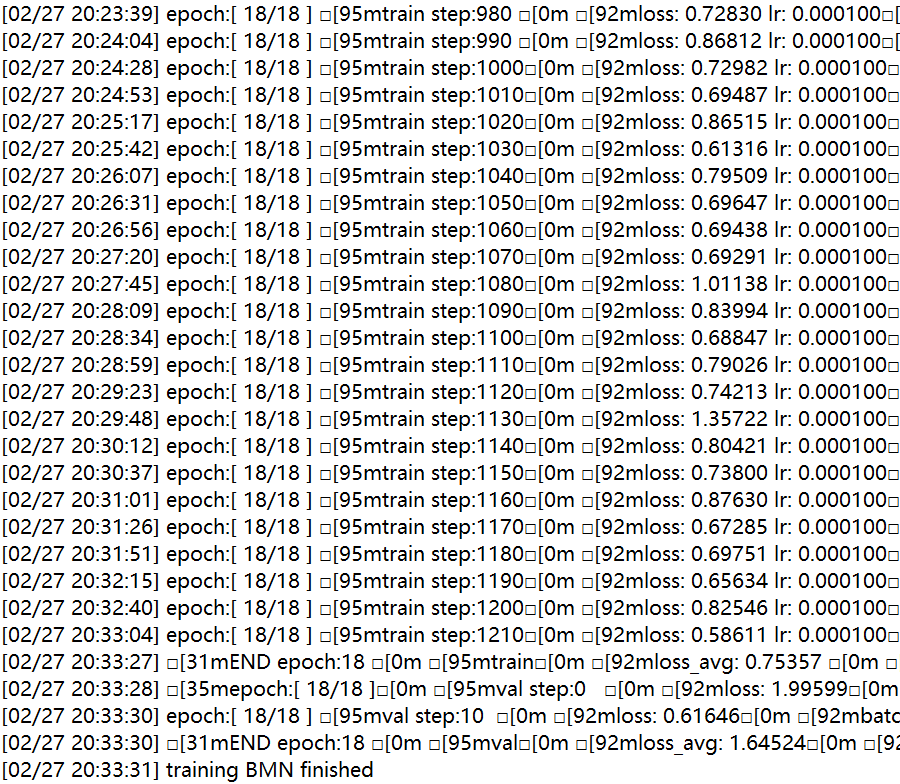

### 模型导出
将训练好的模型导出用于推理预测，执行以下脚本。

In [5]:
%cd /home/aistudio/
!python PaddleVideo/tools/export_model.py -c  PaddleVideo/applications/TableTennis/configs/bmn_tabletennis.yaml -p  PaddleVideo/output/BMN/BMN_epoch_00018.pdparams -o PaddleVideo/inference/BMN

/home/aistudio
Building model(BMN)...
W0228 15:04:40.308302   894 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0228 15:04:40.312518   894 device_context.cc:465] device: 0, cuDNN Version: 7.6.
Loading params from (PaddleVideo/output/BMN/BMN_epoch_00018.pdparams)...
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
model (BMN) has been already saved in (PaddleVideo/inference/BMN).


### 推理预测

使用导出的模型进行推理预测，执行以下命令。

In [ ]:
%cd /home/aistudio/PaddleVideo/
!python tools/predict.py --input_file /home/aistudio/data/Features_competition_test_B/npy \
 --config configs/localization/bmn.yaml \
 --model_file inference/BMN/BMN.pdmodel \
 --params_file inference/BMN/BMN.pdiparams \
 --use_gpu=True \
 --use_tensorrt=False

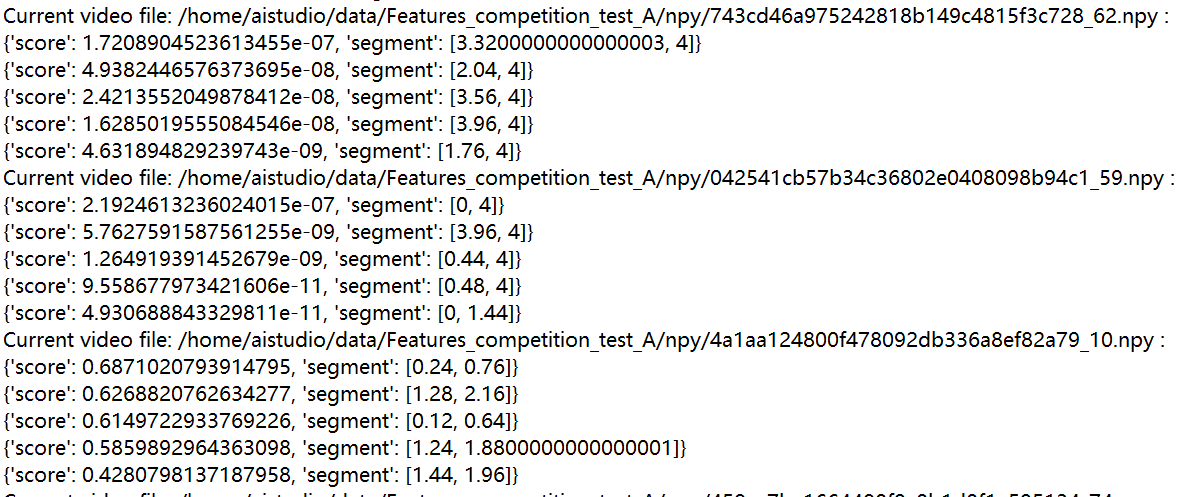

上面程序输出的json文件是分割后的预测结果，还需要将这些文件组合到一起。执行以下脚本：

In [6]:
import os
import json
import glob

json_path = "/home/aistudio/data/Features_competition_test_B/npy/"
json_files = glob.glob(os.path.join(json_path, '*_*.json'))

In [7]:
len(json_files)

8190

In [8]:
submit_dic = {"version": None,
              "results": {},
              "external_data": {}
              }
results = submit_dic['results']
for json_file in json_files:
    j = json.load(open(json_file, 'r'))
    old_video_name = list(j.keys())[0]
    video_name = list(j.keys())[0].split('/')[-1].split('.')[0]
    video_name, video_no = video_name.split('_')
    start_id = int(video_no) * 4
    if len(j[old_video_name]) == 0:
        continue
    for i, top in enumerate(j[old_video_name]):
        if video_name in results.keys():
            results[video_name].append({'score': round(top['score'], 2),
                                        'segment': [round(top['segment'][0] + start_id, 2), round(top['segment'][1] + start_id, 2)]})
        else:
            results[video_name] = [{'score':round(top['score'], 2),
                                        'segment': [round(top['segment'][0] + start_id, 2), round(top['segment'][1] + start_id, 2)]}]

json.dump(submit_dic, open('/home/aistudio/submission.json', 'w', encoding='utf-8'))

最后会在用户目录生成submission.json文件，压缩后下载提交即可。

In [9]:
%cd /home/aistudio/
!zip submission.zip submission.json

/home/aistudio
updating: submission.json (deflated 91%)


最终A榜得分44.45754， B榜得分45.22373

### 总结和改进思路

1. 尝试了[SSTAP](https://openaccess.thecvf.com/content/CVPR2021/html/Wang_Self-Supervised_Learning_for_Semi-Supervised_Temporal_Action_Proposal_CVPR_2021_paper.html)中的"Temporal feature shift"进行数据扩增，效果不增反降，可能是使用方法不对。

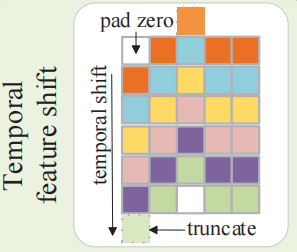

2. BMN输出的proposal后处理方法只采用了不可学习的NMS方法，没有尝试引入Softer-nms等。

3. 没有引入PGCN等图神经网络对Proposal进行后处理，或许可以提高效果。



